# Some analysis of the Swedish archive of conscripts

In [1]:
#ESIM	STRING	Ej simkunnig
#LASV	STRING	Läs-skrivsvårighet. 1=läs och skrivsvårigheter. F r o m 1984.
#PENR	STRING	Personnummer
#INST	STRING	Inställelsedatum
#PPRF_BEFL	STRING	Befälslämplighet
#LNGD	STRING	Längd i cm
#MASS	STRING	Vikt i kg
codes_to_read = ['ESIM', 'LASV', 'PENR', 'INST', 'PPRF_BEFL', 'LNGD', 'MASS']

import os.path
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

INSARK_DB = "insark_db.npz"
if os.path.exists(INSARK_DB):
    data = np.load(INSARK_DB)
else:
    print("Loading data...", end="")
    t = time.time()
    data = {}
    for code in codes_to_read:
        data[code] = list()
    def to_int(d):
        try:
            if len(d)>0:
                return int(d)
        except:
            pass
        return None
    with open("INSARK.csv") as datafile:
        codes = datafile.readline().split('\t')
        codes[-1] = codes[-1].strip('\n')
        for linenumber, textline in enumerate(datafile):
            #print(textline)
            split_line = textline.split('\t')
            for code in codes_to_read:
                d = split_line[codes.index(code)].strip()
                if code in ['LNGD', 'MASS', 'ESIM', 'LASV', 'PPRF_BEFL', 'INST']:
                    d = to_int(d)
                data[code].append(d)
            #if linenumber > 100000:
            #    break
    # Clean up the data
    data['PENR'] = [to_int(e[:4]) for e in data['PENR']]
    mask = [data['LNGD'][i] is not None and data['MASS'][i] is not None for i in range(len(data['LNGD']))]
    mask = [mask[i] and data['LNGD'][i]>0 and data['MASS'][i]>0 for i in range(len(mask))]
    mask = [mask[i] and data['PENR'][i] is not None for i in range(len(mask))]
    for code in codes_to_read:
        data[code] = [e for i, e in enumerate(data[code]) if mask[i]]   
    data['LNGD'] = np.asarray(data['LNGD'], dtype=np.int)
    data['MASS'] = np.asarray(data['MASS'], dtype=np.int)
    data['PENR'] = np.asarray(data['PENR'], dtype=np.int)
    data['INST'] = np.asarray([0 if e is None else e for e in data['INST']], dtype=np.int)
    data['ESIM'] = np.asarray([0 if e is None else e for e in data['ESIM']], dtype=np.bool)
    data['LASV'] = np.asarray([0 if e is None else e for e in data['LASV']], dtype=np.bool)
    data['PPRF_BEFL'] = np.asarray([-1 if e is None else e for e in data['PPRF_BEFL']], dtype=np.int)

    np.savez_compressed(INSARK_DB, **data)
    print("done (%.1fs)" % (time.time()-t))

In [2]:
length = data['LNGD']
weight = data['MASS']
born = data['PENR']//100
mask = np.percentile(weight, .5) < weight
mask *= weight < np.percentile(weight, 99.5)
mask *= np.percentile(length, .5) < length
mask *= length < np.percentile(length, 99.5)
print("Removing %.1f%% as outliers" % (100*(1 - np.sum(mask)/mask.shape[0])))
length = length[mask]
weight = weight[mask]
born = born[mask]

Removing 2.2% as outliers


Lengths and weights can now be plotted.

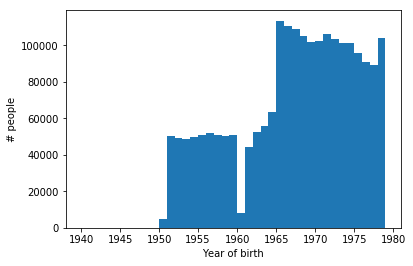

In [3]:
plt.figure()
plt.hist(born+1900, np.unique(born+1900))
plt.xlabel("Year of birth")
plt.ylabel("# people");
plt.show()

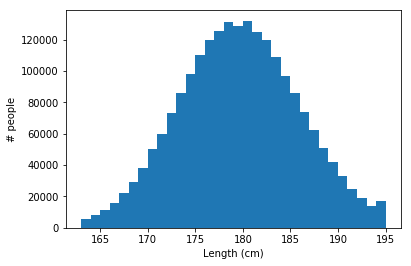

In [4]:
plt.figure()
plt.hist(length, np.unique(length))
plt.xlabel("Length (cm)")
plt.ylabel("# people")
plt.show()

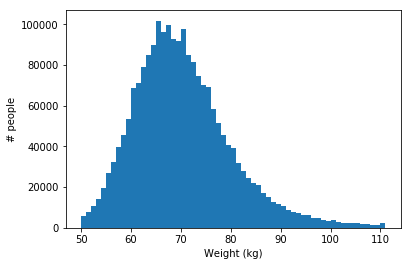

In [5]:
plt.figure()
plt.hist(weight, np.unique(weight))
plt.xlabel("Weight (kg)")
plt.ylabel("# people")
plt.show()

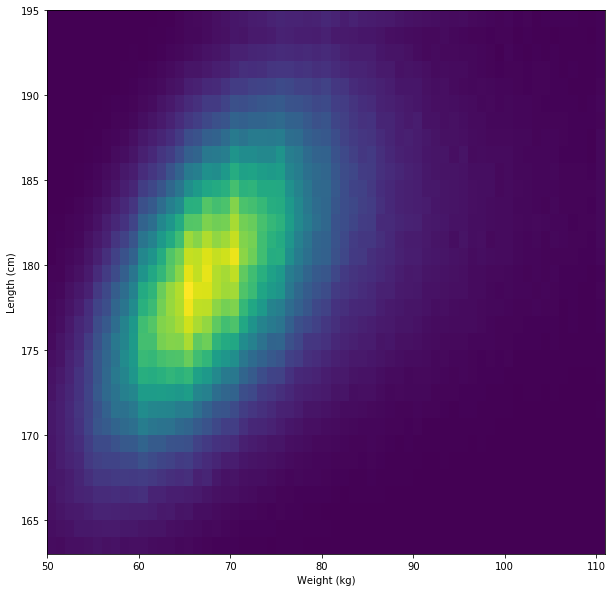

In [6]:
plt.figure(figsize=(10, 10))
plt.hist2d(weight, length, [np.unique(weight), np.unique(length)])
plt.xlabel("Weight (kg)")
plt.ylabel("Length (cm)")
plt.show()

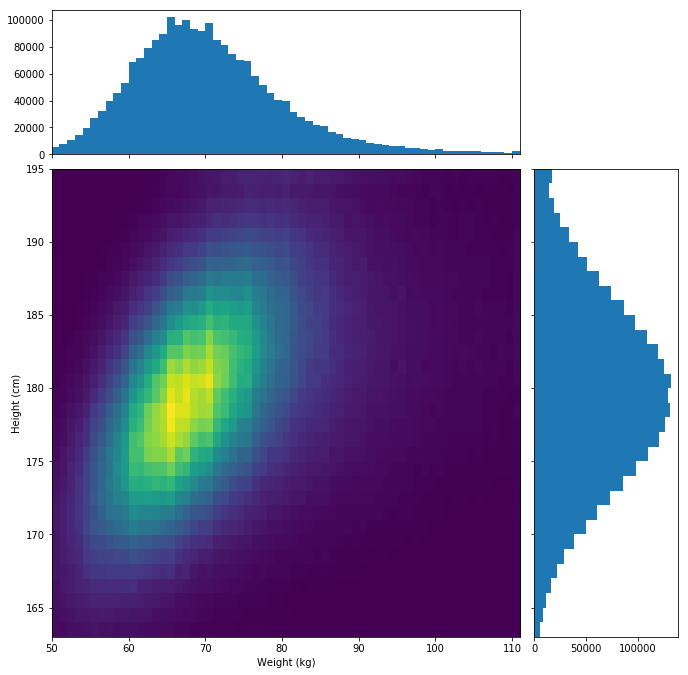

In [7]:
from matplotlib.ticker import NullFormatter

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(10, 10))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.hist2d(weight, length, [np.unique(weight), np.unique(length)])
axHistx.hist(weight, bins=np.unique(weight))
axHisty.hist(length, bins=np.unique(length), orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.set_xlabel("Weight (kg)")
axScatter.set_ylabel("Height (cm)")

plt.show()